In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
df1 = pd.read_csv('data/trips_2018_cleaned.csv')

In [11]:
df1.tail()


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week
17527736,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336,40.730477,-73.999061,379,40.749156,-73.991600,27111,Subscriber,1986,1,734.239,2018-12-31,23,Monday,12,1
17527737,2551,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,3320,40.794067,-73.962868,2006,40.765909,-73.976342,16390,Customer,1969,0,2551.475,2018-12-31,23,Monday,12,1
17527738,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427,40.701907,-74.013942,259,40.701221,-74.012342,34398,Subscriber,1979,1,2376.436,2018-12-31,23,Monday,12,1
17527739,2758,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,3320,40.794067,-73.962868,281,40.764397,-73.973715,30818,Customer,1969,0,2758.305,2018-12-31,23,Monday,12,1
17527740,2459,2018-12-31 23:59:51.085,2019-01-01 00:40:50.880,128,40.727103,-74.002971,402,40.740343,-73.989551,34775,Subscriber,1996,2,2459.795,2018-12-31,23,Monday,12,1


# Task 1

In [12]:
all_stations = pd.concat([
    df1[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    df1[['end_station_id', 'end_station_latitude', 'end_station_longitude']].rename(
        columns={'end_station_id': 'start_station_id',
                 'end_station_latitude': 'start_station_latitude',
                 'end_station_longitude': 'start_station_longitude'}
    )
]).drop_duplicates().dropna()

print(f"Total unique stations: {len(all_stations)}")

Total unique stations: 845


Coordinate range:
  Lat: 4511766 to 4530398 meters
  Lon: -6297109 to -6282158 meters

Testing different K values...
K=1: Inertia=2.09e+10
K=4: Inertia=4.29e+09
K=7: Inertia=2.28e+09
K=10: Inertia=1.47e+09
K=13: Inertia=1.09e+09
K=16: Inertia=8.64e+08
K=19: Inertia=7.23e+08
K=22: Inertia=6.22e+08
K=25: Inertia=5.45e+08
K=28: Inertia=4.80e+08
K=31: Inertia=4.20e+08
K=34: Inertia=3.81e+08
K=37: Inertia=3.46e+08
K=40: Inertia=3.15e+08
K=43: Inertia=2.91e+08
K=46: Inertia=2.69e+08
K=49: Inertia=2.53e+08


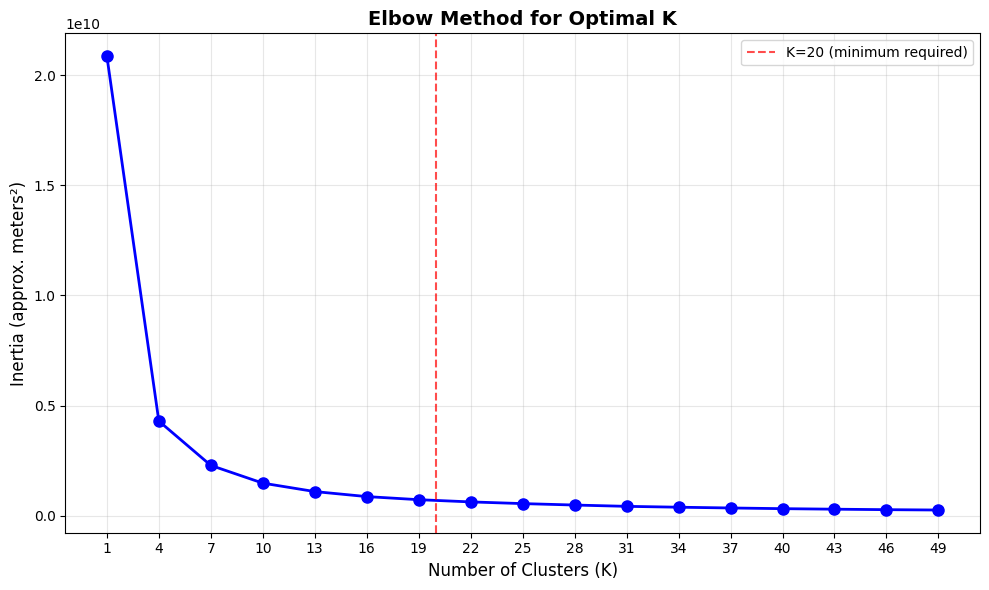

In [13]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# CONVERT LAT/LON TO APPROXIMATE METERS

lat = all_stations['start_station_latitude'].values
lon = all_stations['start_station_longitude'].values

# Approximate conversion for New York area (40.7°N)
# 1 degree latitude ≈ 111,000 meters
# 1 degree longitude ≈ 85,000 meters (at 40°N latitude)

lat_meters = lat * 111000  # meters
lon_meters = lon * 85000   # meters (adjusted for NYC latitude)

X_meters = np.column_stack([lat_meters, lon_meters])

print(f"Coordinate range:")
print(f"  Lat: {lat_meters.min():.0f} to {lat_meters.max():.0f} meters")
print(f"  Lon: {lon_meters.min():.0f} to {lon_meters.max():.0f} meters")

# ELBOW METHOD TO FIND OPTIMAL K

X = X_meters

k_values = range(1, 51, 3)
inertias = []

print("\nTesting different K values...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=67, n_init=20)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia={kmeans.inertia_:.2e}")

# ============================================================================
# PLOT ELBOW CURVE
# ============================================================================

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (approx. meters²)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='K=20 (minimum required)')
plt.legend()

plt.tight_layout()
plt.savefig('elbow_plot_meters.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
kmeans = KMeans(n_clusters=20, random_state=67, n_init=20)
all_stations['cluster'] = kmeans.fit_predict(X_meters)

In [15]:
station_to_cluster = dict(zip(
    all_stations['start_station_id'], 
    all_stations['cluster']
))

# Add to df1
df1['start_cluster'] = df1['start_station_id'].map(station_to_cluster)
df1['end_cluster'] = df1['end_station_id'].map(station_to_cluster)

# Verify
print(f"\nMissing start clusters: {df1['start_cluster'].isna().sum()}")
print(f"Missing end clusters: {df1['end_cluster'].isna().sum()}")

df1.head()


Missing start clusters: 0
Missing end clusters: 0


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,...,1992,1,970.752,2018-01-01,13,Monday,1,1,12,16
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,...,1969,1,723.159,2018-01-01,15,Monday,1,1,12,16
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,...,1956,1,496.835,2018-01-01,15,Monday,1,1,12,12
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,...,1974,1,306.819,2018-01-01,15,Monday,1,1,12,12
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,...,1992,1,306.074,2018-01-01,18,Monday,1,1,12,1


# Task 2

In [16]:
# Selecting top 3 clusters by total demand for analysis
cluster_demand = df1.groupby('start_cluster').size().sort_values(ascending=False)
selected_clusters = cluster_demand.head(3).index.tolist()

print(f"SELECTED CLUSTERS FOR PREDICTION: {selected_clusters}")


for cluster_id in selected_clusters:
    total_pickups = cluster_demand[cluster_id]
    num_stations = df1[df1['start_cluster'] == cluster_id]['start_station_id'].nunique()
    print(f"\nCluster {cluster_id}:")
    print(f"  - Total pickups: {total_pickups:,}")
    print(f"  - Number of stations: {num_stations}")

SELECTED CLUSTERS FOR PREDICTION: [16, 0, 18]

Cluster 16:
  - Total pickups: 2,546,906
  - Number of stations: 49

Cluster 0:
  - Total pickups: 2,381,714
  - Number of stations: 51

Cluster 18:
  - Total pickups: 1,909,563
  - Number of stations: 58


## Feature Helper Functions

In [17]:
# Feature Engineering Functions
import pandas as pd
import numpy as np

def aggregate_hourly_demand(df, cluster_id, target='pickups'):
    if target == 'pickups':
        cluster_trips = df[df['start_cluster'] == cluster_id].copy()
    else:
        cluster_trips = df[df['end_cluster'] == cluster_id].copy()
    
    cluster_trips['timestamp'] = pd.to_datetime(cluster_trips['date']) + pd.to_timedelta(cluster_trips['hour'], unit='h')
    hourly_counts = cluster_trips.groupby('timestamp').size().reset_index(name=target)
    hourly_counts = hourly_counts.set_index('timestamp').sort_index()
    
    full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
    hourly_counts = hourly_counts.reindex(full_range, fill_value=0)
    
    return hourly_counts

def add_time_features(hourly_data):
    df = hourly_data.copy()
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    # Assuming you have a 'day_of_week' column (0=Monday, 6=Sunday)
    df['is_rush_hour'] = (df['hour_of_day'].isin([7, 8, 9, 17, 18, 19]) & df['day_of_week'] < 5).astype(int)
    return df

def add_lag_features(hourly_data, target_col):
    df = hourly_data.copy()
    df['lag_1h'] = df[target_col].shift(1)
    df['lag_24h'] = df[target_col].shift(24)
    df['lag_168h'] = df[target_col].shift(168)
    return df

def add_rolling_features(hourly_data, target_col):
    df = hourly_data.copy()
    df['avg_last_3h'] = df[target_col].shift(1).rolling(window=3).mean()
    df['avg_last_24h'] = df[target_col].shift(1).rolling(window=24).mean()
    df['max_last_24h'] = df[target_col].shift(1).rolling(window=24).max()
    return df

def add_cyclical_features(hourly_data, target_col, train_cutoff='2018-10-31 23:59:59'):
    """
    Calculate only on training data.
    """
    df = hourly_data.copy()
    
    # Only use training data to calculate statistics
    train_data = df[df.index <= train_cutoff]
    
    # Hour of day stats
    hour_stats = train_data.groupby('hour_of_day')[target_col].mean()
    df['typical_hour_mean'] = df['hour_of_day'].map(hour_stats)
    
    # Day of week stats
    dow_stats = train_data.groupby('day_of_week')[target_col].mean()
    df['typical_dow_mean'] = df['day_of_week'].map(dow_stats)
    
    return df



## Complete Feature Function

In [18]:
def build_all_features(df, cluster_id, target='pickups'):
    hourly_data = aggregate_hourly_demand(df, cluster_id, target)
    hourly_data = add_time_features(hourly_data)
    hourly_data = add_lag_features(hourly_data, target)
    hourly_data = add_rolling_features(hourly_data, target)
    hourly_data = add_cyclical_features(hourly_data, target)
    hourly_data = hourly_data.dropna()
    return hourly_data

In [19]:
# Build features for all clusters
all_cluster_features = {}

for cluster_id in selected_clusters:
    pickups_features = build_all_features(df1, cluster_id, target='pickups')
    dropoffs_features = build_all_features(df1, cluster_id, target='dropoffs')
    
    all_cluster_features[cluster_id] = {
        'pickups': pickups_features,
        'dropoffs': dropoffs_features
    }
    
    print(f"Cluster {cluster_id}: {pickups_features.shape[0]} samples, {pickups_features.shape[1]} features")

/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_91384/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_91384/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')


Cluster 16: 8592 samples, 14 features


/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_91384/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_91384/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')


Cluster 0: 8592 samples, 14 features


/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_91384/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_91384/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')


Cluster 18: 8592 samples, 14 features


# Train / Test splits

In [20]:
# Train/test split
def split_time_series_data(ts_features, cutoff_date='2018-10-31 23:59:59', target='pickups'):
    feature_columns = [col for col in ts_features.columns if col not in [target]]
    
    train_mask = ts_features.index <= cutoff_date
    test_mask = ts_features.index > cutoff_date
    
    X_train = ts_features.loc[train_mask, feature_columns]
    y_train = ts_features.loc[train_mask, target]
    X_test = ts_features.loc[test_mask, feature_columns]
    y_test = ts_features.loc[test_mask, target]
    
    return X_train, X_test, y_train, y_test

# Models 

In [21]:
# Evaluation metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def print_stats(y_test, y_preds, title="Model"):
    print(f"{title}:")
    print(f"\tR² = {r2_score(y_test, y_preds):.4f}")
    print(f"\tRMSE = {np.sqrt(mean_squared_error(y_test, y_preds)):.2f}")
    print(f"\tMAE = {mean_absolute_error(y_test, y_preds):.2f}")

In [41]:
# Train models and store them
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

results = []
trained_models = {}  # Add this to store models

for cluster_id in selected_clusters:
    trained_models[cluster_id] = {'pickups': {}, 'dropoffs': {}}  # Initialize storage
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*60}")
    
    for target in ['pickups', 'dropoffs']:
        print(f"\n{target.upper()}:")
        
        # Get features
        ts_data = all_cluster_features[cluster_id][target]
        
        # Split data
        X_train, X_test, y_train, y_test = split_time_series_data(ts_data, target=target)
        
        # Baseline: Last week
        baseline_pred = ts_data.loc[y_test.index, 'lag_168h'].values
        print_stats(y_test, baseline_pred, "Baseline (Last Week)")
        
        # Ridge Regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train_scaled, y_train)
        ridge_pred = np.maximum(ridge.predict(X_test_scaled), 0)
        print_stats(y_test, ridge_pred, "Ridge")
        
        # Gradient Boosting
        gb = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
        gb.fit(X_train, y_train)
        gb_pred = np.maximum(gb.predict(X_test), 0)
        print_stats(y_test, gb_pred, "Gradient Boosting")
        
        # STORE THE MODELS (NEW)
        trained_models[cluster_id][target] = {
            'gb': gb,
            'ridge': ridge,
            'scaler': scaler,
            'X_test': X_test,
            'y_test': y_test,
            'gb_pred': gb_pred
        }
        
        results.append({
            'cluster': cluster_id,
            'target': target,
            'baseline_rmse': np.sqrt(mean_squared_error(y_test, baseline_pred)),
            'ridge_rmse': np.sqrt(mean_squared_error(y_test, ridge_pred)),
            'gb_rmse': np.sqrt(mean_squared_error(y_test, gb_pred))
        })


CLUSTER 16

PICKUPS:
Baseline (Last Week):
	R² = 0.4884
	RMSE = 165.45
	MAE = 92.41
Ridge:
	R² = 0.8152
	RMSE = 99.44
	MAE = 64.71
Gradient Boosting:
	R² = 0.9455
	RMSE = 53.98
	MAE = 31.48

DROPOFFS:
Baseline (Last Week):
	R² = 0.5114
	RMSE = 167.61
	MAE = 93.01
Ridge:
	R² = 0.8178
	RMSE = 102.35
	MAE = 66.22
Gradient Boosting:
	R² = 0.9569
	RMSE = 49.78
	MAE = 30.22

CLUSTER 0

PICKUPS:
Baseline (Last Week):
	R² = 0.4228
	RMSE = 145.85
	MAE = 87.09
Ridge:
	R² = 0.8525
	RMSE = 73.72
	MAE = 50.19
Gradient Boosting:
	R² = 0.9499
	RMSE = 42.97
	MAE = 26.90

DROPOFFS:
Baseline (Last Week):
	R² = 0.4586
	RMSE = 149.84
	MAE = 87.28
Ridge:
	R² = 0.8396
	RMSE = 81.56
	MAE = 54.52
Gradient Boosting:
	R² = 0.9499
	RMSE = 45.60
	MAE = 28.51

CLUSTER 18

PICKUPS:
Baseline (Last Week):
	R² = 0.5196
	RMSE = 111.27
	MAE = 64.79
Ridge:
	R² = 0.7999
	RMSE = 71.81
	MAE = 47.64
Gradient Boosting:
	R² = 0.9482
	RMSE = 36.53
	MAE = 23.74

DROPOFFS:
Baseline (Last Week):
	R² = 0.4722
	RMSE = 115.66
	MAE =

In [42]:
# Results summary
results_df = pd.DataFrame(results)
print("\n", results_df)


    cluster    target  baseline_rmse  ridge_rmse    gb_rmse
0       16   pickups     165.451176   99.443429  53.977428
1       16  dropoffs     167.610603  102.354784  49.781189
2        0   pickups     145.847980   73.719051  42.970698
3        0  dropoffs     149.844708   81.555103  45.596830
4       18   pickups     111.266068   71.810206  36.532316
5       18  dropoffs     115.663127   62.675051  43.913933


In [43]:
def calculate_required_bikes(predictions_df, cluster_id):
    """
    Calculate the number of bikes required at the start of the day for a cluster.
    
    Parameters:
    -----------
    predictions_df : DataFrame
        Must contain columns: 'hour', 'pickups_pred', 'dropoffs_pred'
        (or actual values if using ground truth)
    cluster_id : int
        The cluster identifier
    
    Returns:
    --------
    dict with required bikes and analysis details
    """
    # Calculate net flow (departures - arrivals)
    # Positive = more bikes leaving, Negative = more bikes arriving
    predictions_df['net_flow'] = predictions_df['pickups_pred'] - predictions_df['dropoffs_pred']
    
    # Calculate cumulative net flow
    predictions_df['cumulative_flow'] = predictions_df['net_flow'].cumsum()
    
    # Find the minimum cumulative flow
    min_cumulative = predictions_df['cumulative_flow'].min()
    
    # Required bikes = absolute value of the minimum (if negative)
    # If minimum is positive, we never have a deficit
    required_bikes = max(0, -min_cumulative)
    
    # Find when the deficit is worst
    worst_hour = predictions_df.loc[predictions_df['cumulative_flow'].idxmin(), 'hour']
    
    return {
        'cluster_id': cluster_id,
        'required_bikes': int(np.ceil(required_bikes)),
        'worst_deficit_hour': worst_hour,
        'min_cumulative_flow': min_cumulative,
        'total_pickups': predictions_df['pickups_pred'].sum(),
        'total_dropoffs': predictions_df['dropoffs_pred'].sum(),
        'net_daily_flow': predictions_df['net_flow'].sum()
    }




In [44]:

def compute_repositioning_for_all_clusters(all_predictions, selected_clusters):
    """
    Compute required bikes for all clusters.
    
    Parameters:
    -----------
    all_predictions : dict
        Dictionary with cluster_id as keys and DataFrames with predictions as values
    selected_clusters : list
        List of cluster IDs to analyze
    
    Returns:
    --------
    DataFrame with repositioning requirements for each cluster
    """
    repositioning_results = []
    
    for cluster_id in selected_clusters:
        # Get predictions for this cluster
        cluster_preds = all_predictions[cluster_id]
        
        # Calculate requirements
        result = calculate_required_bikes(cluster_preds, cluster_id)
        repositioning_results.append(result)
    
    return pd.DataFrame(repositioning_results)

In [45]:
# Generate predictions for "next day" using test set (simulating operational scenario)
all_predictions = {}

for cluster_id in selected_clusters:
    # Get trained Gradient Boosting models (best performers)
    gb_pickups = trained_models[cluster_id]['pickups']['gb']
    gb_dropoffs = trained_models[cluster_id]['dropoffs']['gb']
    
    # Get test features
    X_test_p = trained_models[cluster_id]['pickups']['X_test']
    X_test_d = trained_models[cluster_id]['dropoffs']['X_test']
    
    # Select first 24 hours of test set to simulate "next day"
    hours_to_predict = min(24, len(X_test_p))
    
    # Make predictions
    pickups_pred = np.maximum(gb_pickups.predict(X_test_p[:hours_to_predict]), 0)
    dropoffs_pred = np.maximum(gb_dropoffs.predict(X_test_d[:hours_to_predict]), 0)
    
    # Create predictions DataFrame
    all_predictions[cluster_id] = pd.DataFrame({
        'hour': range(hours_to_predict),
        'pickups_pred': pickups_pred,
        'dropoffs_pred': dropoffs_pred
    })
    
print("Predictions generated for all clusters")
print(f"Sample - Cluster {selected_clusters[0]} predictions:")
print(all_predictions[selected_clusters[0]].head())

Predictions generated for all clusters
Sample - Cluster 16 predictions:
   hour  pickups_pred  dropoffs_pred
0     0     68.543722     107.142118
1     1     28.199233      42.146232
2     2     19.741581      20.765365
3     3     10.191768       9.544297
4     4     19.260626      18.513421


In [46]:
# Calculate repositioning requirements for all clusters
repositioning_df = compute_repositioning_for_all_clusters(all_predictions, selected_clusters)

print("\n" + "="*80)
print("OVERNIGHT BIKE REPOSITIONING PLAN")
print("="*80)
print(repositioning_df[['cluster_id', 'required_bikes', 'worst_deficit_hour', 'net_daily_flow']])
print(f"\nTotal bikes to reposition across all clusters: {repositioning_df['required_bikes'].sum()}")
print("\nCluster Analysis:")
for _, row in repositioning_df.iterrows():
    flow_type = "net exporter" if row['net_daily_flow'] > 0 else "net receiver"
    print(f"  Cluster {row['cluster_id']}: {row['required_bikes']} bikes needed, {flow_type}")


OVERNIGHT BIKE REPOSITIONING PLAN
   cluster_id  required_bikes  worst_deficit_hour  net_daily_flow
0          16             667                  16     -351.911344
1           0             528                  14     -149.916474
2          18             204                  23     -203.151480

Total bikes to reposition across all clusters: 1399

Cluster Analysis:
  Cluster 16.0: 667.0 bikes needed, net receiver
  Cluster 0.0: 528.0 bikes needed, net receiver
  Cluster 18.0: 204.0 bikes needed, net receiver


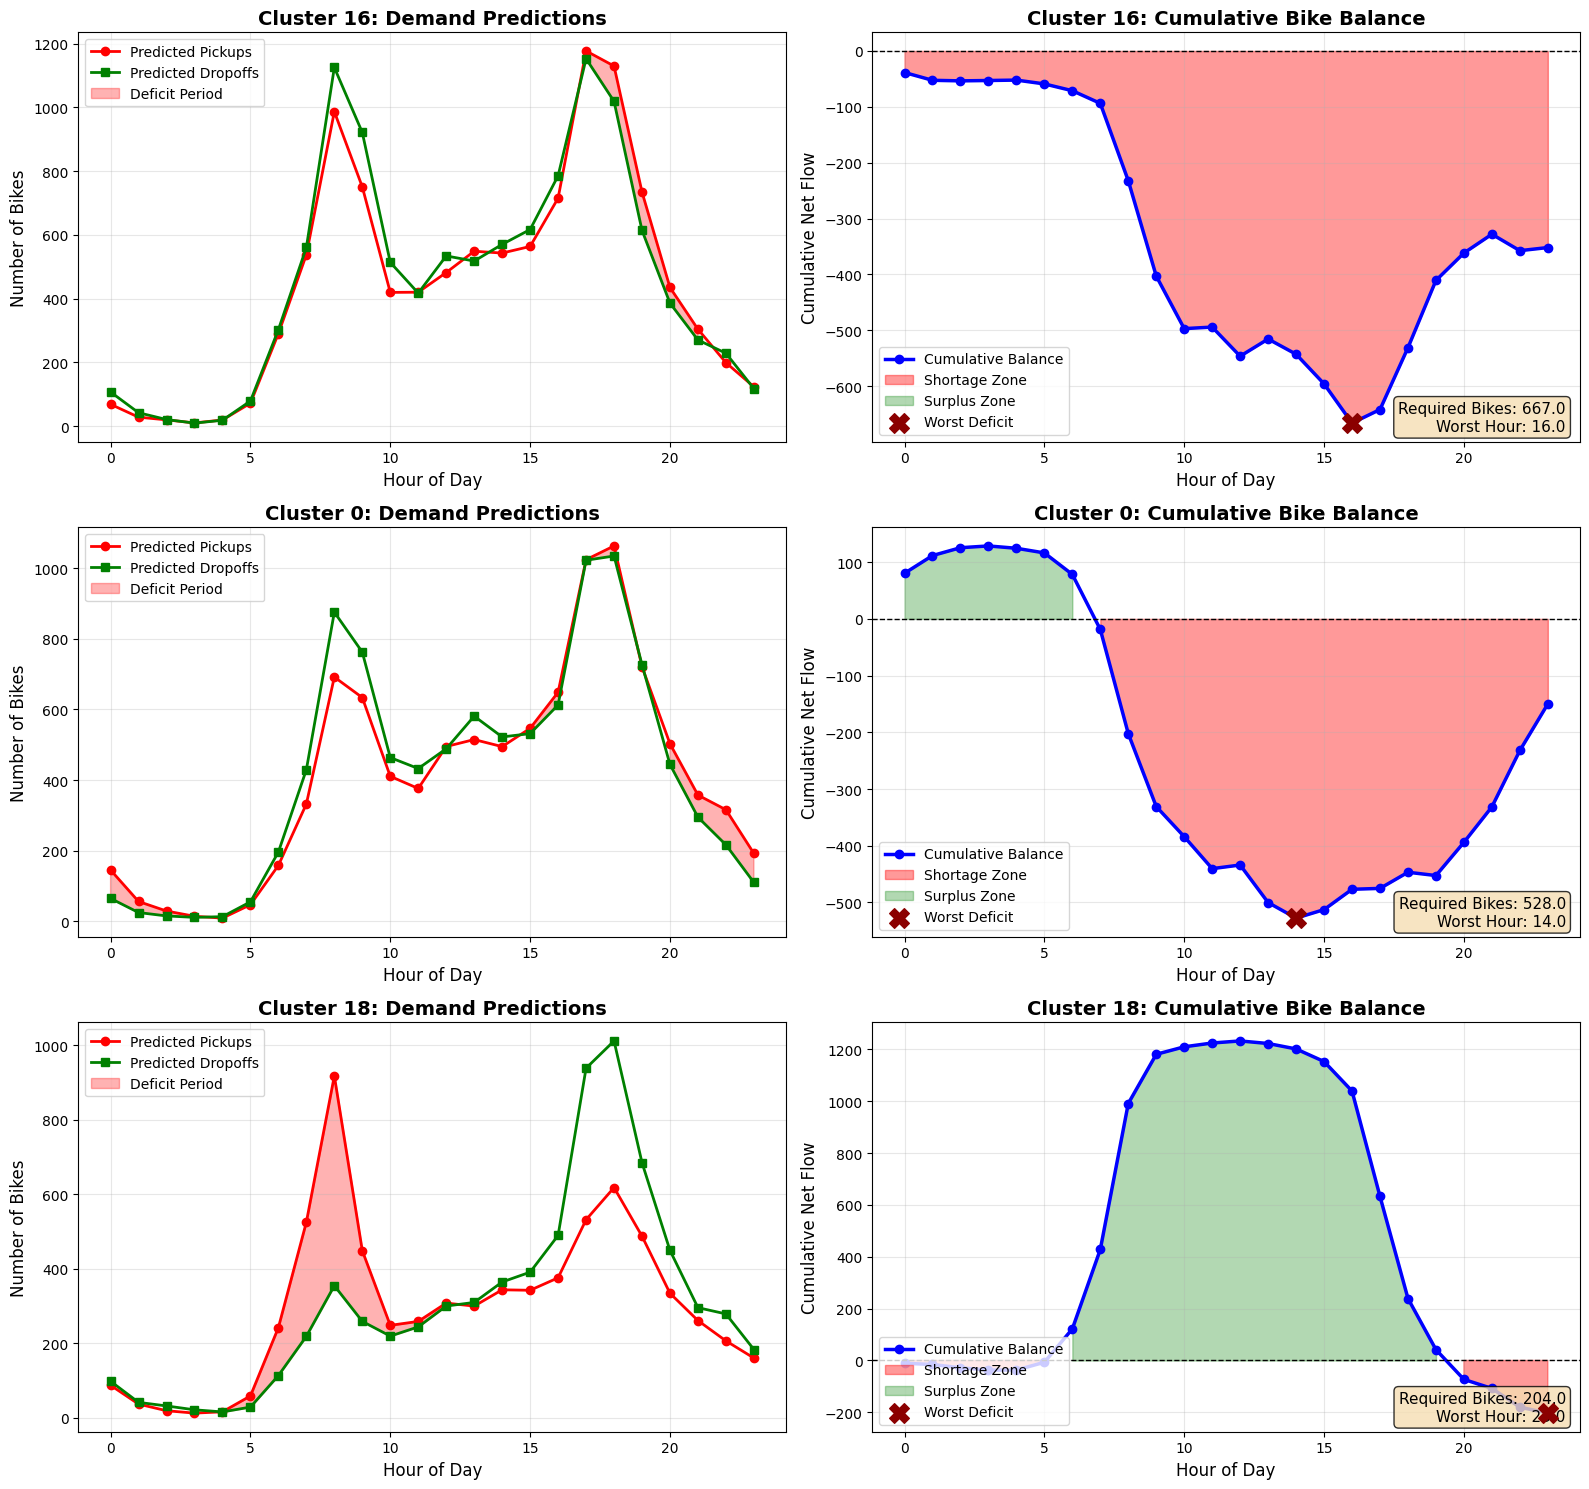

In [47]:
# Visualize repositioning strategy for each cluster
fig, axes = plt.subplots(len(selected_clusters), 2, figsize=(16, 5*len(selected_clusters)))

for idx, cluster_id in enumerate(selected_clusters):
    # Get predictions and calculate flows
    preds = all_predictions[cluster_id].copy()
    preds['net_flow'] = preds['pickups_pred'] - preds['dropoffs_pred']
    preds['cumulative_flow'] = preds['net_flow'].cumsum()
    
    # Get repositioning info
    repo_info = repositioning_df[repositioning_df['cluster_id'] == cluster_id].iloc[0]
    
    # LEFT PLOT: Pickups vs Dropoffs
    axes[idx, 0].plot(preds['hour'], preds['pickups_pred'], 
                      marker='o', label='Predicted Pickups', color='red', linewidth=2)
    axes[idx, 0].plot(preds['hour'], preds['dropoffs_pred'], 
                      marker='s', label='Predicted Dropoffs', color='green', linewidth=2)
    axes[idx, 0].fill_between(preds['hour'], preds['pickups_pred'], preds['dropoffs_pred'],
                              where=(preds['pickups_pred'] > preds['dropoffs_pred']),
                              alpha=0.3, color='red', label='Deficit Period')
    axes[idx, 0].set_title(f'Cluster {cluster_id}: Demand Predictions', fontsize=14, fontweight='bold')
    axes[idx, 0].set_xlabel('Hour of Day', fontsize=12)
    axes[idx, 0].set_ylabel('Number of Bikes', fontsize=12)
    axes[idx, 0].legend(loc='upper left')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # RIGHT PLOT: Cumulative Flow
    axes[idx, 1].plot(preds['hour'], preds['cumulative_flow'], 
                     marker='o', linewidth=2.5, color='blue', label='Cumulative Balance')
    axes[idx, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[idx, 1].fill_between(preds['hour'], preds['cumulative_flow'], 0, 
                             where=(preds['cumulative_flow'] < 0), 
                             color='red', alpha=0.4, label='Shortage Zone')
    axes[idx, 1].fill_between(preds['hour'], preds['cumulative_flow'], 0, 
                             where=(preds['cumulative_flow'] >= 0), 
                             color='green', alpha=0.3, label='Surplus Zone')
    
    # Mark worst deficit point
    worst_idx = preds['cumulative_flow'].idxmin()
    axes[idx, 1].scatter(preds.loc[worst_idx, 'hour'], preds.loc[worst_idx, 'cumulative_flow'],
                        s=200, color='darkred', marker='X', zorder=5, label='Worst Deficit')
    
    axes[idx, 1].set_title(f'Cluster {cluster_id}: Cumulative Bike Balance', 
                          fontsize=14, fontweight='bold')
    axes[idx, 1].set_xlabel('Hour of Day', fontsize=12)
    axes[idx, 1].set_ylabel('Cumulative Net Flow', fontsize=12)
    axes[idx, 1].legend(loc='lower left')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Add annotation box
    textstr = f'Required Bikes: {repo_info["required_bikes"]}\n'
    textstr += f'Worst Hour: {repo_info["worst_deficit_hour"]}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[idx, 1].text(0.98, 0.02, textstr, transform=axes[idx, 1].transAxes,
                     fontsize=11, verticalalignment='bottom', horizontalalignment='right',
                     bbox=props)

plt.tight_layout()
plt.savefig('repositioning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# Detailed interpretation
print("="*80)
print("REPOSITIONING STRATEGY & BUSINESS RECOMMENDATIONS")
print("="*80)

for _, row in repositioning_df.iterrows():
    cluster_id = row['cluster_id']
    required = row['required_bikes']
    worst_hour = row['worst_deficit_hour']
    net_flow = row['net_daily_flow']
    
    print(f"\n{'─'*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'─'*80}")
    print(f"✓ Initial Positioning: Place {required} bikes before day start")
    print(f"✓ Critical Period: Hour {worst_hour} (peak deficit)")
    print(f"✓ Daily Pattern: {'Net Exporter' if net_flow > 0 else 'Net Receiver'} ({net_flow:+.0f} bikes/day)")
    print(f"✓ Total Activity: {row['total_pickups']:.0f} pickups, {row['total_dropoffs']:.0f} dropoffs")
    
    if net_flow > 0:
        print(f"  → Recommendation: Source cluster - can supply bikes to other clusters")
    else:
        print(f"  → Recommendation: Destination cluster - needs continual replenishment")

print(f"\n{'='*80}")
print(f"SYSTEM-LEVEL SUMMARY:")
print(f"{'='*80}")
print(f"Total bikes needed for initial positioning: {repositioning_df['required_bikes'].sum()}")
print(f"Net system flow should balance: {repositioning_df['net_daily_flow'].sum():.1f} (close to 0)")
print("\nThis repositioning strategy ensures:")
print("  • No cluster runs out of bikes during the day")
print("  • Customer demand is fully met")
print("  • Efficient use of fleet across the system")

REPOSITIONING STRATEGY & BUSINESS RECOMMENDATIONS

────────────────────────────────────────────────────────────────────────────────
CLUSTER 16.0
────────────────────────────────────────────────────────────────────────────────
✓ Initial Positioning: Place 667.0 bikes before day start
✓ Critical Period: Hour 16.0 (peak deficit)
✓ Daily Pattern: Net Receiver (-352 bikes/day)
✓ Total Activity: 10575 pickups, 10927 dropoffs
  → Recommendation: Destination cluster - needs continual replenishment

────────────────────────────────────────────────────────────────────────────────
CLUSTER 0.0
────────────────────────────────────────────────────────────────────────────────
✓ Initial Positioning: Place 528.0 bikes before day start
✓ Critical Period: Hour 14.0 (peak deficit)
✓ Daily Pattern: Net Receiver (-150 bikes/day)
✓ Total Activity: 9784 pickups, 9933 dropoffs
  → Recommendation: Destination cluster - needs continual replenishment

──────────────────────────────────────────────────────────────

In [53]:
# Calculate repositioning using ACTUAL values
all_actuals = {}
for cluster_id in selected_clusters:
    y_test_p = trained_models[cluster_id]['pickups']['y_test']
    y_test_d = trained_models[cluster_id]['dropoffs']['y_test']
    
    hours_to_predict = min(24, len(y_test_p))
    
    all_actuals[cluster_id] = pd.DataFrame({
        'hour': range(hours_to_predict),
        'pickups_pred': y_test_p[:hours_to_predict].values,  # Using actual, not pred
        'dropoffs_pred': y_test_d[:hours_to_predict].values
    })

# Calculate repositioning based on actuals
repositioning_actual = compute_repositioning_for_all_clusters(all_actuals, selected_clusters)

# Compare predicted vs actual
comparison = repositioning_df[['cluster_id', 'required_bikes']].merge(
    repositioning_actual[['cluster_id', 'required_bikes']], 
    on='cluster_id', 
    suffixes=('_predicted', '_actual')
)
comparison['difference'] = comparison['required_bikes_predicted'] - comparison['required_bikes_actual']
comparison['pct_error'] = (comparison['difference'] / comparison['required_bikes_actual'] * 100).round(1)

print("\n" + "="*80)
print("PREDICTED VS ACTUAL REPOSITIONING REQUIREMENTS")
print("="*80)
print(comparison)


PREDICTED VS ACTUAL REPOSITIONING REQUIREMENTS
   cluster_id  required_bikes_predicted  required_bikes_actual  difference  \
0          16                       667                    630          37   
1           0                       528                    538         -10   
2          18                       204                     32         172   

   pct_error  
0        5.9  
1       -1.9  
2      537.5  
